# パッケージインストール

In [ ]:
!pip install -q flash-attn==2.7.0.post2 --no-build-isolation

# サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/Ovis2-Colaboratory-Sample/refs/heads/main/sample.jpg -O sample.jpg

--2025-03-01 09:09:01--  https://user0514.cdnw.net/shared/img/thumb/UNO114281PAR54698_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.105.216.58
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.105.216.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48514 (47K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  47.38K  --.-KB/s    in 0.1s    

2025-03-01 09:09:02 (422 KB/s) - ‘sample.jpg’ saved [48514/48514]



# モデル読み込み

In [ ]:
# モデル選択
model_path = "AIDC-AI/Ovis2-1B"  # L4 GPU
# model_path = "AIDC-AI/Ovis2-2B"  # L4 GPU
# model_path = "AIDC-AI/Ovis2-4B"  # L4 GPU
# model_path = "AIDC-AI/Ovis2-8B"  # L4 GPU
# model_path = "AIDC-AI/Ovis2-16B"  # A100 GPU
# model_path = "AIDC-AI/Ovis2-34B"  # 動作不可（A100 GPU）

In [ ]:
import torch
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    multimodal_max_length=32768,
    trust_remote_code=True,
).cuda()
text_tokenizer = model.get_text_tokenizer()
visual_tokenizer = model.get_visual_tokenizer()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/7.18k [00:00<?, ?B/s]

configuration_ovis.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

modeling_aimv2.py:   0%|          | 0.00/6.74k [00:00<?, ?B/s]

configuration_aimv2.py:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/AIDC-AI/Ovis2-1B:
- configuration_aimv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/AIDC-AI/Ovis2-1B:
- modeling_aimv2.py
- configuration_aimv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/AIDC-AI/Ovis2-1B:
- configuration_ovis.py
- modeling_aimv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_ovis.py:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/AIDC-AI/Ovis2-1B:
- modeling_ovis.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


generation_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

# プロンプト生成

In [ ]:
from PIL import Image

images = [Image.open('sample.jpg')]
max_partition = 9
text = '画像を説明してください'
query = f'<image>\n{text}'

prompt, input_ids, pixel_values = model.preprocess_inputs(query, images, max_partition=max_partition)
attention_mask = torch.ne(input_ids, text_tokenizer.pad_token_id)
input_ids = input_ids.unsqueeze(0).to(device=model.device)
attention_mask = attention_mask.unsqueeze(0).to(device=model.device)
if pixel_values is not None:
    pixel_values = pixel_values.to(dtype=visual_tokenizer.dtype, device=visual_tokenizer.device)
pixel_values = [pixel_values]

# 推論

In [ ]:
%%time

with torch.inference_mode():
    gen_kwargs = dict(
        max_new_tokens=1024,
        do_sample=False,
        top_p=None,
        top_k=None,
        temperature=None,
        repetition_penalty=None,
        eos_token_id=model.generation_config.eos_token_id,
        pad_token_id=text_tokenizer.pad_token_id,
        use_cache=True
    )
    output_ids = model.generate(input_ids, pixel_values=pixel_values, attention_mask=attention_mask, **gen_kwargs)[0]
    output = text_tokenizer.decode(output_ids, skip_special_tokens=True)

CPU times: user 4.46 s, sys: 349 ms, total: 4.8 s
Wall time: 5.16 s


# 結果確認

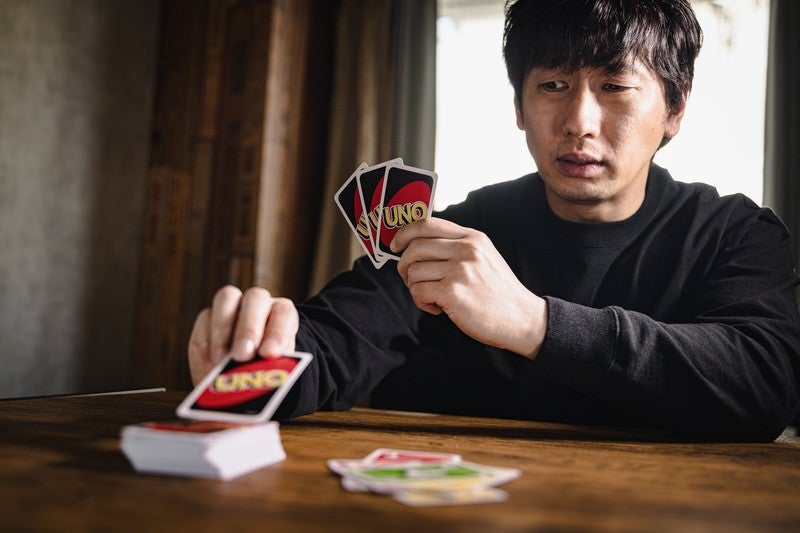

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [ ]:
import textwrap

print(textwrap.fill(output, width=50))

木製のテーブルの上に、黒い長袖のセーターを着た男性がゲームを楽しんでいます。彼は「UNO」のカードを
扇状に持ち、右手でカードを広げています。左手には、もう一度カードを広げているところです。テーブルの上
には、すでに広げられたカードの堆があり、その横にいくつかのカードが散らばっています。男性は真剣な表情
で、ゲームに集中している様子が伺えます。背景には、木製の壁とカーテンが見え、落ち着いた雰囲気です。
